In [41]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb
from hyperopt import fmin, hp, tpe, Trials
from hyperopt.pyll.base import scope
from functools import partial
from hyperopt import base
base.have_bson = False

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report

In [95]:
df = pd.read_csv('online_shoppers_intention (1).csv')

In [96]:
cat_cols = [col for col in df.columns if df[col].dtypes in ['object', 'bool'] and col not in ['Revenue']]
cat_cols

['Month', 'VisitorType', 'Weekend']

In [19]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates in %,ExitRates in %,PageValues,SpecialDay (probability),...,TrafficType,VisitorType,Weekend,Revenue,OperatingSystems_agg,Browser_agg,TrafficType_agg,AllPageCount,AllPageCount_Duration,BounceRates_x_PageValues
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,1,2,0,False,1,1,1,1,0.000000,0.0
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,...,2,2,0,False,2,2,2,2,64.000000,0.0
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,3,2,0,False,other,1,3,1,0.000000,0.0
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,...,4,2,0,False,3,2,4,2,2.666667,0.0
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,...,4,2,1,False,3,other,4,10,627.500000,0.0


In [43]:
month_encoded = df.groupby('Month').size() / len(df)
df['Month_frequency_encoded'] = df['Month'].apply(lambda x: month_encoded[x])

In [44]:
visitor_type_encoded = df.groupby('VisitorType').size() / len(df)
df['VisitorType_frequency_encoded'] = df['VisitorType'].apply(lambda x: visitor_type_encoded[x])

In [45]:
weekend_encoded = df.groupby('Weekend').size() / len(df)
df['Weekend_frequency_encoded'] = df['Weekend'].apply(lambda x: weekend_encoded[x])

In [63]:
for col in ['Weekend']:
    le = LabelEncoder()
    df.loc[:, col] = le.fit_transform(df[col])

In [97]:
for col in cat_cols:
    le = LabelEncoder()
    df.loc[:, col] = le.fit_transform(df[col])

C:\Users\lenovo\AppData\Local\Temp\ipykernel_10672\1663346978.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, col] = le.fit_transform(df[col])
C:\Users\lenovo\AppData\Local\Temp\ipykernel_10672\1663346978.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, col] = le.fit_transform(df[col])


In [65]:
df["OperatingSystems_agg"] = df["OperatingSystems"].apply(lambda x: "other" if x >=4 else x)
df["Browser_agg"] = df["Browser"].apply(lambda x: "other" if x not in [1,2,4] else x)

traffic_type_pct = 100*df["TrafficType"].value_counts().to_frame()/df.shape[0]
traffic_idx_list = traffic_type_pct[traffic_type_pct["TrafficType"] >= 2].index
df["TrafficType_agg"] = df["TrafficType"].apply(lambda x: x if x in traffic_idx_list else "other")

df["AllPageCount"] = df[["Administrative", "Informational", "ProductRelated"]].sum(axis=1)
df["AllPageCount_Duration"] = df[["Administrative_Duration", "Informational_Duration", "ProductRelated_Duration"]].sum(axis=1)

df["BounceRates_x_PageValues"] = df["BounceRates in %"] * df["PageValues"]

In [ ]:
product_view_percent = df['ProductRelated'].value_counts(normalize=True)

In [133]:
null_frame.loc[null_frame['nan'] > 0, :]

,index,nan
19,product_view_percent,6
20,product_dur_percent,18
21,ave_product_duration,38
22,admin_view_percent,6
23,admin_dur_percent,706
24,ave_admin_duration,5768
25,info_view_percent,6
26,info_dur_percent,714
27,ave_info_duration,9699
30,page_values_per_product_view,38


In [129]:
df['PageValues'] / df['Informational_Duration']

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
12325    inf
12326    NaN
12327    NaN
12328    NaN
12329    NaN
Length: 12330, dtype: float64

In [67]:
df = pd.get_dummies(data=df, columns=cat_cols)

In [65]:
num_cols = [col for col in df.columns if df[col].dtypes in ['int64', 'float64'] and col not in ['Revenue']]
for col in num_cols:
    scaler = StandardScaler()
    df.loc[:, col] = scaler.fit_transform(df[col].values.reshape(-1, 1))

In [82]:
num_cols = [col for col in df.columns if df[col].dtypes in ['int64', 'float64'] and col not in ['Revenue']]
for col in num_cols:
    scaler = RobustScaler()
    df.loc[:, col] = scaler.fit_transform(df[col].values.reshape(-1, 1))

In [202]:
null_frame = X.isnull().sum().reset_index(name='nan')

In [106]:
X = df.drop('Revenue', axis=1)
y = df['Revenue']

In [107]:
n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

In [108]:
from sklearn.ensemble import RandomForestClassifier

In [109]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [110]:
print(classification_report(preds, y_test))

              precision    recall  f1-score   support

       False       0.96      0.92      0.94      1088
        True       0.57      0.74      0.64       145

    accuracy                           0.90      1233
   macro avg       0.76      0.83      0.79      1233
weighted avg       0.92      0.90      0.91      1233



In [40]:
n_features = range(10, 48, 2)
for i in n_features:
    select = RFE(RandomForestClassifier(), n_features_to_select=i)

    select.fit(X_train, y_train)

    mask = select.get_support()

    X_train_rfe = select.transform(X_train)
    X_test_rfe = select.transform(X_test)
    model = RandomForestClassifier().fit(X_train_rfe, y_train)
    preds = model.predict(X_test_rfe)
    score = recall_score(preds, y_test)
    
    print("Test score: {:.3f}".format(score), " number of features: {}".format(i))

Test score: 0.741  number of features: 10
Test score: 0.697  number of features: 12
Test score: 0.735  number of features: 14
Test score: 0.725  number of features: 16
Test score: 0.714  number of features: 18


KeyboardInterrupt: 

In [111]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [112]:
print(classification_report(preds, y_test))

              precision    recall  f1-score   support

           0       0.95      0.92      0.94      1074
           1       0.57      0.69      0.62       159

    accuracy                           0.89      1233
   macro avg       0.76      0.80      0.78      1233
weighted avg       0.90      0.89      0.90      1233



In [9]:
feat_imp = pd.DataFrame(model.feature_importances_, index=X.columns)
feat_imp = feat_imp.reset_index()
feat_imp = feat_imp.rename(columns={'index': 'Features', 0: 'Importances'})
feat_imp

,Features,Importances
0,Administrative,0.030477
1,Administrative_Duration,0.020870
2,Informational,0.016634
3,Informational_Duration,0.022640
4,ProductRelated,0.024675
5,ProductRelated_Duration,0.025456
6,BounceRates in %,0.033163
7,ExitRates in %,0.024908
8,PageValues,0.217127
9,SpecialDay (probability),0.022719


In [10]:
X.shape

(12330, 29)

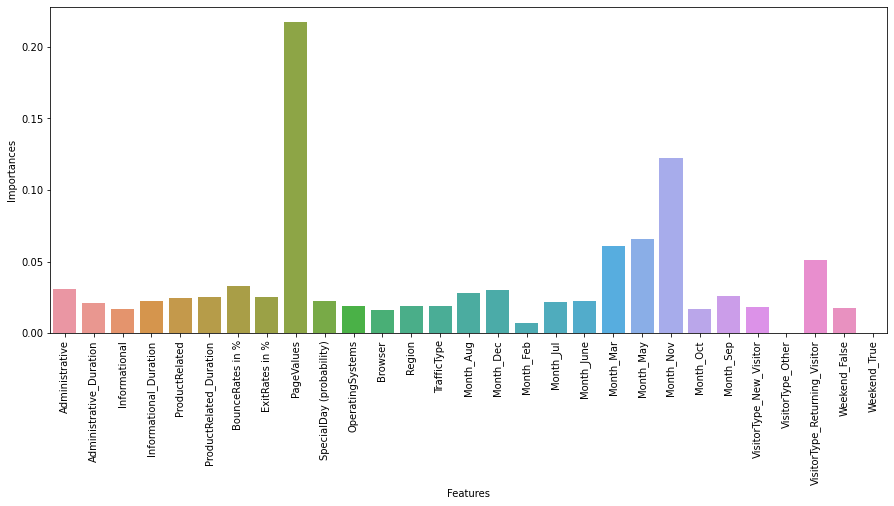

In [11]:
plt.figure(figsize=(15, 6))
sns.barplot(data=feat_imp, x='Features', y='Importances')
plt.xticks(rotation=90)
plt.show()

In [75]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr(numeric_only=True).abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df, 10))

Top Absolute Correlations
ProductRelated           AllPageCount                     0.997179
ProductRelated_Duration  AllPageCount_Duration            0.993910
VisitorType_New_Visitor  VisitorType_Returning_Visitor    0.971911
BounceRates in %         ExitRates in %                   0.913004
ProductRelated           ProductRelated_Duration          0.860927
ProductRelated_Duration  AllPageCount                     0.860482
AllPageCount             AllPageCount_Duration            0.857413
ProductRelated           AllPageCount_Duration            0.852904
OperatingSystems_agg_1   Browser_agg_1                    0.815810
Browser                  Browser_agg_other                0.801430
dtype: float64


In [105]:
outlier_col = ['Administrative_Duration', 'ProductRelated_Duration', 'BounceRates in %', 'SpecialDay (probability)', 
               'ExitRates in %', 'PageValues', 'Informational_Duration']

for i in range(len(outlier_col)):    
    lv, uv = np.percentile(df[[outlier_col[i]]], [0,98])  
    df[[outlier_col[i]]] = np.clip(df[[outlier_col[i]]], lv, uv)

In [33]:
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.feature_selection import RFE
from sklearn.metrics import f1_score,recall_score

In [217]:
n_features = range(10, 48, 2)
for i in n_features:
    select = RFE(xgb.XGBClassifier(), n_features_to_select=i)

    select.fit(X_train, y_train)

    mask = select.get_support()

    X_train_rfe = select.transform(X_train)
    X_test_rfe = select.transform(X_test)
    model = xgb.XGBClassifier().fit(X_train_rfe, y_train)
    preds = model.predict(X_test_rfe)
    score = recall_score(preds, y_test)
    
    print("Test score: {:.3f}".format(score), " number of features: {}".format(i))

Test score: 0.682  number of features: 10
Test score: 0.686  number of features: 12
Test score: 0.689  number of features: 14
Test score: 0.675  number of features: 16
Test score: 0.677  number of features: 18
Test score: 0.700  number of features: 20
Test score: 0.713  number of features: 22
Test score: 0.690  number of features: 24
Test score: 0.724  number of features: 26
Test score: 0.731  number of features: 28
Test score: 0.713  number of features: 30
Test score: 0.709  number of features: 32
Test score: 0.720  number of features: 34
Test score: 0.734  number of features: 36
Test score: 0.728  number of features: 38
Test score: 0.713  number of features: 40
Test score: 0.727  number of features: 42
Test score: 0.726  number of features: 44
Test score: 0.726  number of features: 46


In [218]:
n_features = range(11, 48, 2)
for i in n_features:
    select = RFE(xgb.XGBClassifier(), n_features_to_select=i)

    select.fit(X_train, y_train)

    mask = select.get_support()

    X_train_rfe = select.transform(X_train)
    X_test_rfe = select.transform(X_test)
    model = xgb.XGBClassifier().fit(X_train_rfe, y_train)
    preds = model.predict(X_test_rfe)
    score = recall_score(preds, y_test)
    
    print("Test score: {:.3f}".format(score), " number of features: {}".format(i))

Test score: 0.703  number of features: 11
Test score: 0.655  number of features: 13
Test score: 0.667  number of features: 15
Test score: 0.696  number of features: 17
Test score: 0.683  number of features: 19
Test score: 0.701  number of features: 21
Test score: 0.691  number of features: 23
Test score: 0.683  number of features: 25
Test score: 0.655  number of features: 27
Test score: 0.703  number of features: 29
Test score: 0.692  number of features: 31
Test score: 0.697  number of features: 33
Test score: 0.693  number of features: 35
Test score: 0.720  number of features: 37
Test score: 0.713  number of features: 39
Test score: 0.722  number of features: 41
Test score: 0.701  number of features: 43
Test score: 0.726  number of features: 45
Test score: 0.726  number of features: 47


In [113]:
n_features_to_select = 28
rfe = RFE(xgb.XGBClassifier(), n_features_to_select=n_features_to_select)
rfe.fit(X_train, y_train)

RFE(estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                            colsample_bylevel=None, colsample_bynode=None,
                            colsample_bytree=None, early_stopping_rounds=None,
                            enable_categorical=False, eval_metric=None,
                            gamma=None, gpu_id=None, grow_policy=None,
                            importance_type=None, interaction_constraints=None,
                            learning_rate=None, max_bin=None,
                            max_cat_to_onehot=None, max_delta_step=None,
                            max_depth=None, max_leaves=None,
                            min_child_weight=None, missing=nan,
                            monotone_constraints=None, n_estimators=100,
                            n_jobs=None, num_parallel_tree=None, predictor=None,
                            random_state=None, reg_alpha=None, reg_lambda=None, ...),
    n_features_to_select=28)

In [114]:
preds = rfe.predict(X_test)

In [115]:
print(classification_report(preds, y_test))

              precision    recall  f1-score   support

           0       0.95      0.92      0.94      1074
           1       0.57      0.69      0.62       159

    accuracy                           0.89      1233
   macro avg       0.76      0.80      0.78      1233
weighted avg       0.90      0.89      0.90      1233



In [87]:
from operator import itemgetter

features = X_train.columns.to_list()
top_features = []

for rank, feature in sorted(zip(rfe.ranking_, features), key=itemgetter(0)):
    top_features.append(feature)
    if len(top_features) == 28:
        break

print(top_features)

['Administrative', 'Administrative_Duration', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates in %', 'ExitRates in %', 'PageValues', 'Region', 'TrafficType', 'Weekend', 'AllPageCount', 'AllPageCount_Duration', 'BounceRates_x_PageValues', 'Month_Dec', 'Month_Jul', 'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Sep', 'VisitorType_Returning_Visitor', 'OperatingSystems_agg_2', 'Browser_agg_4', 'TrafficType_agg_3', 'TrafficType_agg_4', 'TrafficType_agg_5', 'TrafficType_agg_8', 'TrafficType_agg_11']


In [226]:
from operator import itemgetter
features = X_train.columns.to_list()
for x, y in (sorted(zip(rfe.ranking_ , features), key=itemgetter(0))):
    print(x, y)

1 Administrative
1 Administrative_Duration
1 Informational_Duration
1 ProductRelated
1 ProductRelated_Duration
1 BounceRates in %
1 ExitRates in %
1 PageValues
1 OperatingSystems
1 TrafficType
1 Weekend
1 BounceRates_x_PageValues
1 Month_Dec
1 Month_Jul
1 Month_Mar
1 Month_May
1 Month_Nov
1 Month_Sep
1 VisitorType_New_Visitor
1 VisitorType_Returning_Visitor
1 OperatingSystems_agg_2
1 Browser_agg_4
1 TrafficType_agg_3
1 TrafficType_agg_4
1 TrafficType_agg_5
1 TrafficType_agg_8
1 TrafficType_agg_11
1 TrafficType_agg_13
2 SpecialDay (probability)
3 OperatingSystems_agg_3
4 Month_Aug
5 Informational
6 Region
7 TrafficType_agg_2
8 Month_Oct
9 Browser
10 TrafficType_agg_6
11 TrafficType_agg_other
12 TrafficType_agg_10
13 Month_June
14 Browser_agg_2
15 Browser_agg_other
16 VisitorType_Other
17 Month_Feb
18 TrafficType_agg_1
19 OperatingSystems_agg_1
20 OperatingSystems_agg_other
21 Browser_agg_1


In [88]:
X_to_use = X[top_features]
X_to_use

,Administrative,Administrative_Duration,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates in %,ExitRates in %,PageValues,Region,TrafficType,...,Month_Nov,Month_Sep,VisitorType_Returning_Visitor,OperatingSystems_agg_2,Browser_agg_4,TrafficType_agg_3,TrafficType_agg_4,TrafficType_agg_5,TrafficType_agg_8,TrafficType_agg_11
0,0,0.0,0.0,1,0.000000,0.200000,0.200000,0.000000,1,1,...,0,0,1,0,0,0,0,0,0,0
1,0,0.0,0.0,2,64.000000,0.000000,0.100000,0.000000,1,2,...,0,0,1,1,0,0,0,0,0,0
2,0,0.0,0.0,1,0.000000,0.200000,0.200000,0.000000,9,3,...,0,0,1,0,0,1,0,0,0,0
3,0,0.0,0.0,2,2.666667,0.050000,0.140000,0.000000,2,4,...,0,0,1,0,0,0,1,0,0,0
4,0,0.0,0.0,10,627.500000,0.020000,0.050000,0.000000,1,4,...,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,3,145.0,0.0,53,1783.791667,0.007143,0.029031,12.241717,1,1,...,0,0,1,0,0,0,0,0,0,0
12326,0,0.0,0.0,5,465.750000,0.000000,0.021333,0.000000,1,8,...,1,0,1,0,0,0,0,0,1,0
12327,0,0.0,0.0,6,184.250000,0.083333,0.086667,0.000000,1,13,...,1,0,1,0,0,0,0,0,0,0
12328,4,75.0,0.0,15,346.000000,0.000000,0.021053,0.000000,3,11,...,1,0,1,1,0,0,0,0,0,1


In [89]:
y = df['Revenue']

In [90]:
n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
for fold, (train_idx, test_idx) in enumerate(skf.split(X_to_use, y)):
    X_train, X_test = X_to_use.iloc[train_idx], X_to_use.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

In [91]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [92]:
print(classification_report(preds, y_test))

              precision    recall  f1-score   support

           0       0.95      0.92      0.94      1076
           1       0.57      0.69      0.63       157

    accuracy                           0.89      1233
   macro avg       0.76      0.81      0.78      1233
weighted avg       0.91      0.89      0.90      1233



In [242]:
def optimize(params, X, y):
    model = xgb.XGBClassifier(**params)
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    f1_scores = []
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        f1_scores.append(f1_score(y_test, pred))
    return np.mean(f1_scores)

In [277]:
param_space = {
    'eta': scope.int(hp.quniform('eta', 0.001, 0.9, 0.001)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 50, 1)),
    'max_leaves': scope.int(hp.quniform('max_leaves', 10, 1000, 10))}

optimization_function = partial(optimize, X=X_to_use, y=y)
trials = Trials()
results = fmin(
    fn=optimization_function,
    space=param_space,
    max_evals=100,
    trials=trials,
    algo=tpe.suggest
)

100%|█████████████████████████████████████████████████████████████| 100/100 [23:33<00:00, 14.13s/trial, best loss: 0.0]


In [278]:
results

{'eta': 0.082, 'max_depth': 28.0, 'max_leaves': 650.0}

In [130]:
params = {'eta': 0.082, 'max_depth': 28, 'max_leaves': 650}

In [283]:
model = xgb.XGBClassifier(**params)
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [284]:
print(classification_report(preds, y_test))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1067
           1       0.61      0.70      0.65       166

    accuracy                           0.90      1233
   macro avg       0.78      0.81      0.80      1233
weighted avg       0.91      0.90      0.90      1233



In [285]:
import shap

In [287]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


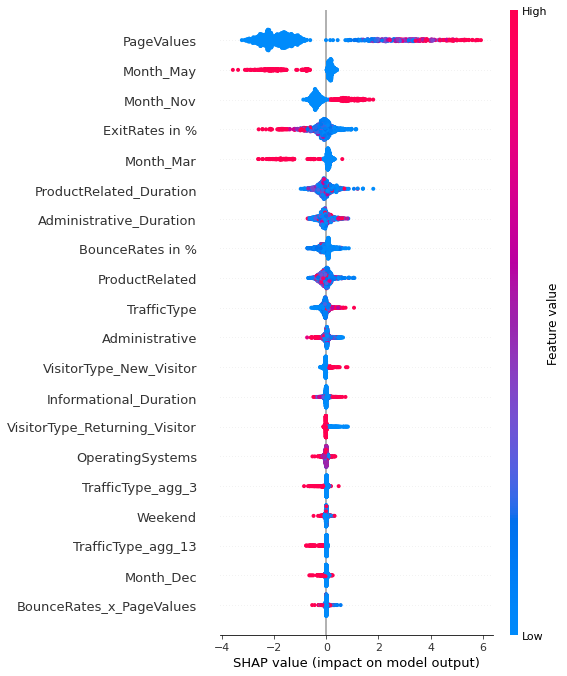

In [288]:
shap.summary_plot(shap_values, X_test)
plt.show()

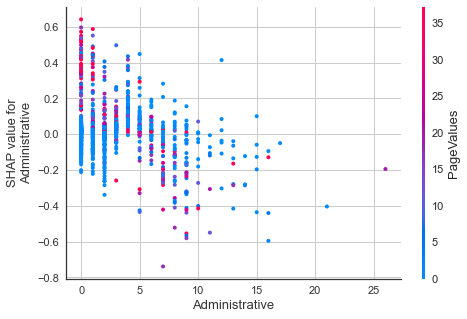

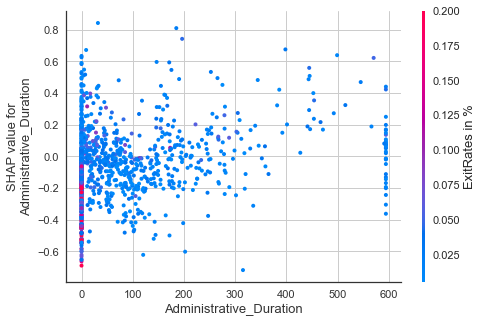

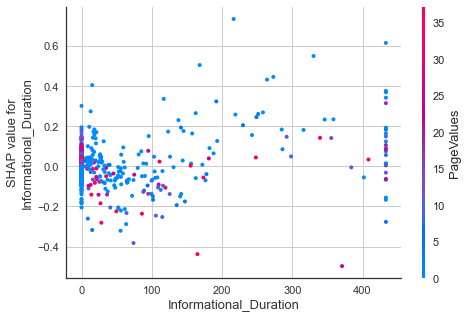

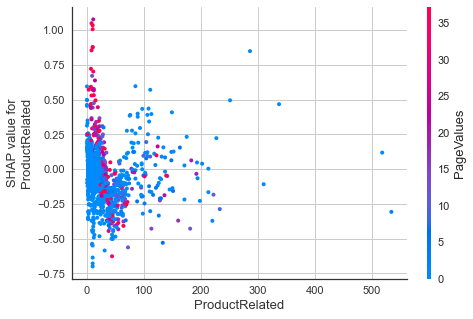

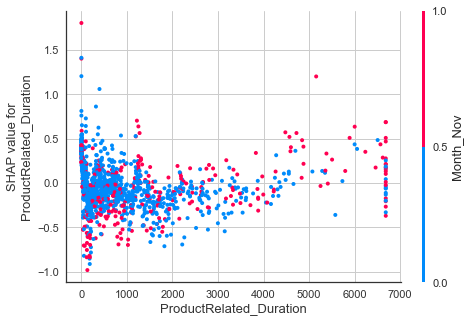

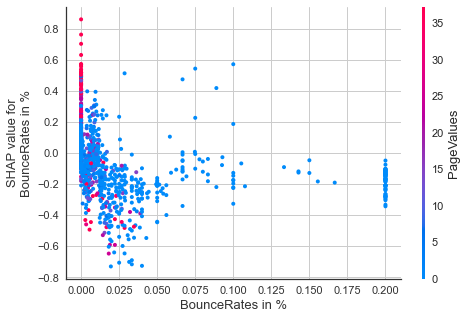

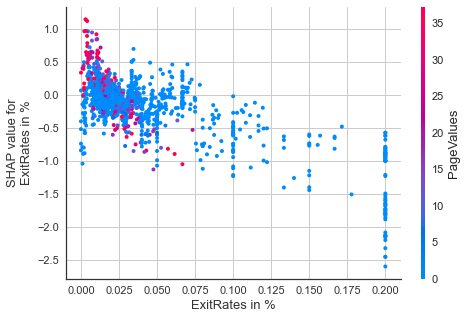

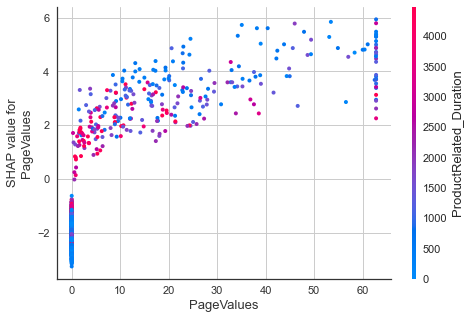

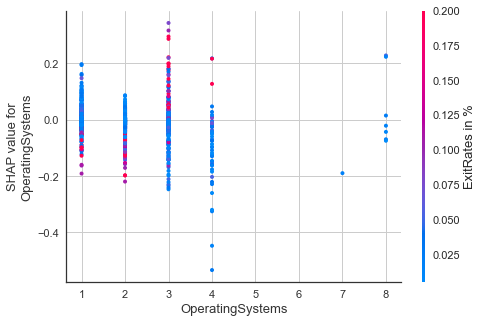

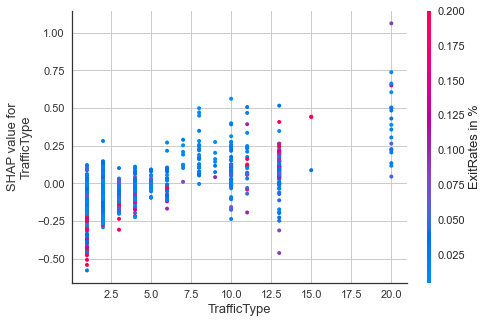

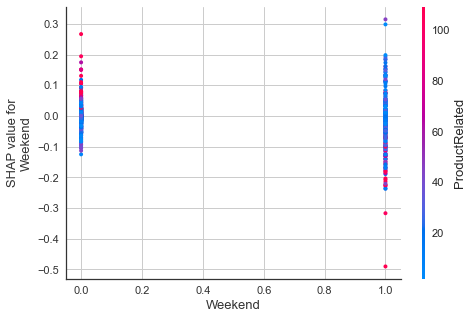

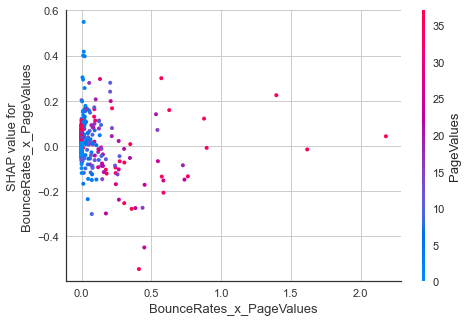

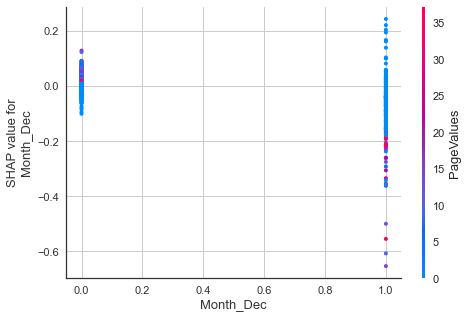

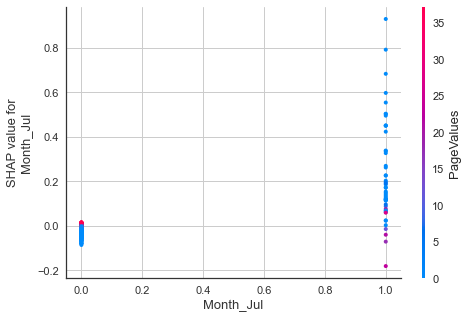

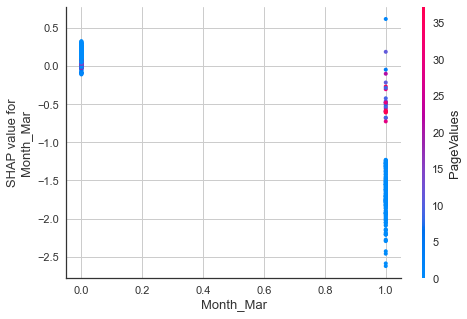

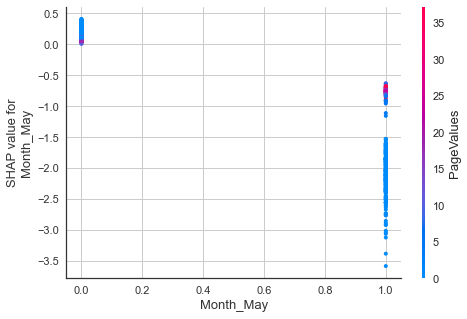

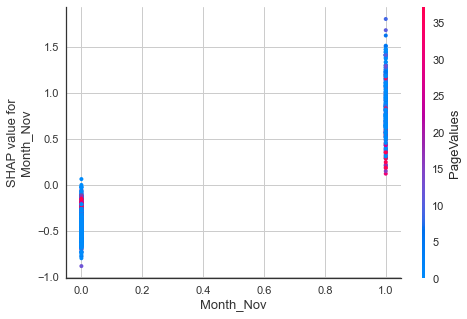

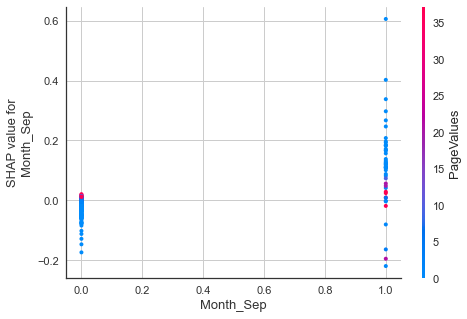

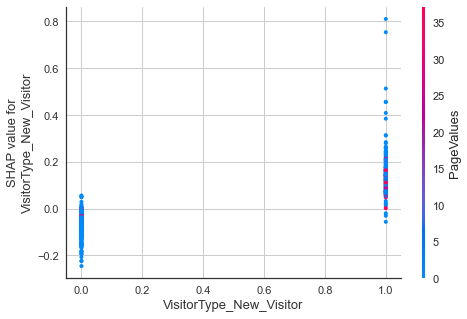

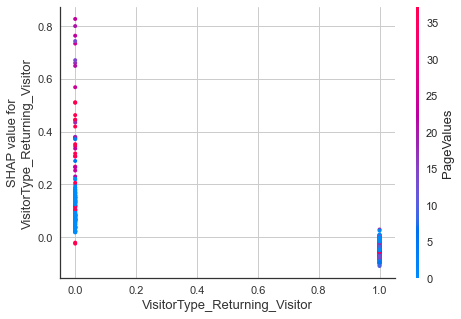

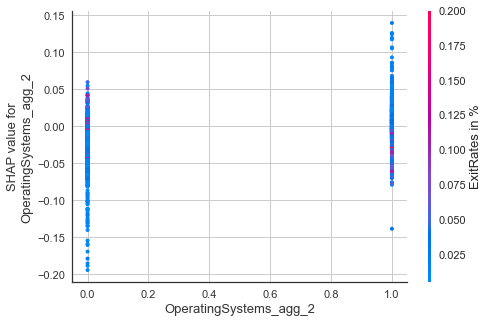

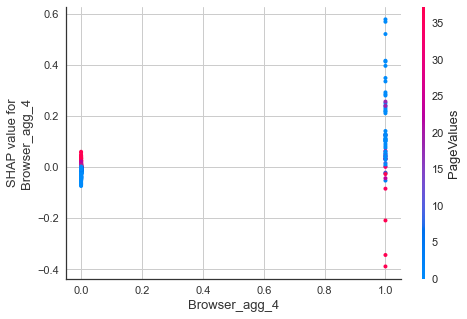

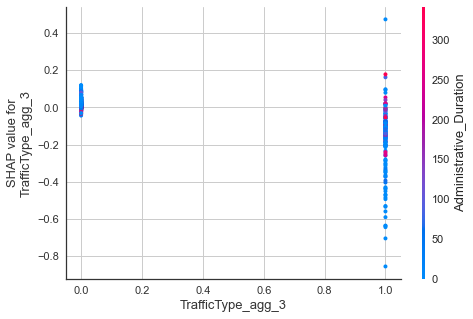

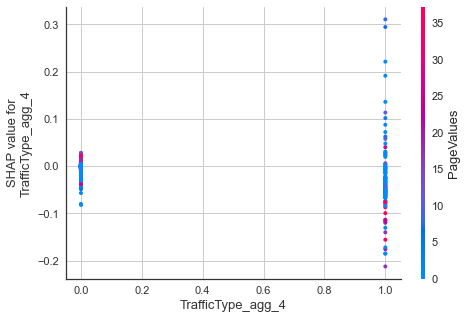

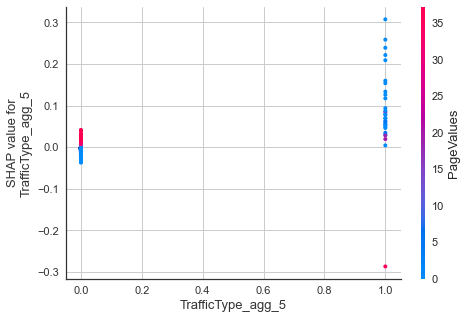

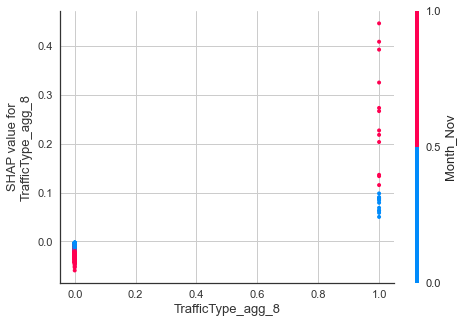

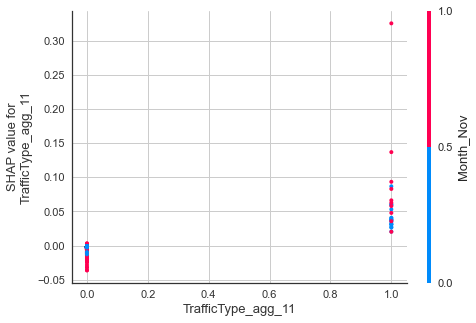

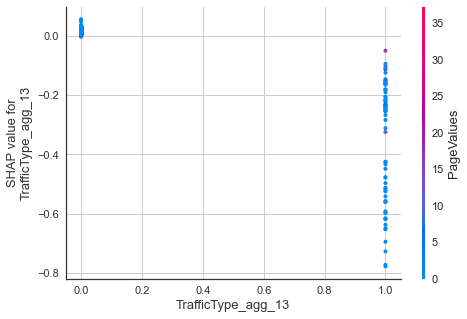

In [296]:
for i in X_train.columns:
    shap.dependence_plot(i, shap_values, X_test)

In [289]:
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.classifier import DiscriminationThreshold

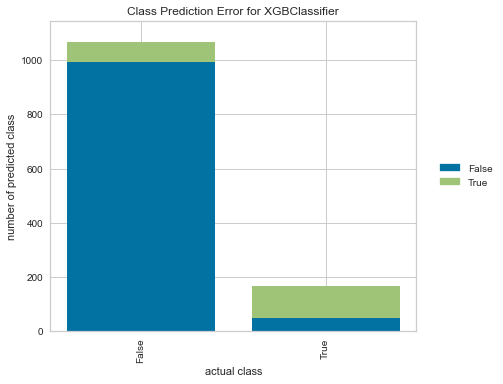

<AxesSubplot:title={'center':'Class Prediction Error for XGBClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [290]:
visualizer = ClassPredictionError(model)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show() 

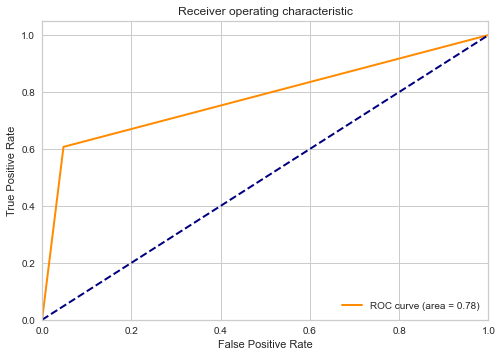

In [291]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

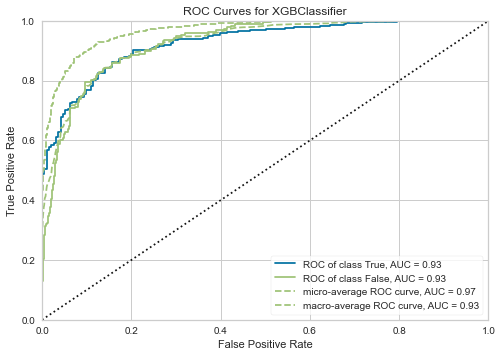

<AxesSubplot:title={'center':'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [293]:
visualizer = ROCAUC(model, classes=["True", "False"])

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()   

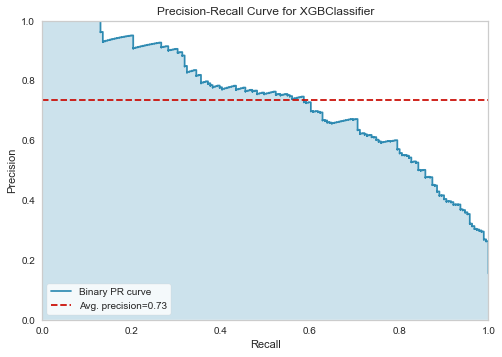

<AxesSubplot:title={'center':'Precision-Recall Curve for XGBClassifier'}, xlabel='Recall', ylabel='Precision'>

In [292]:
viz = PrecisionRecallCurve(model)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

In [294]:
from yellowbrick.features import RadViz

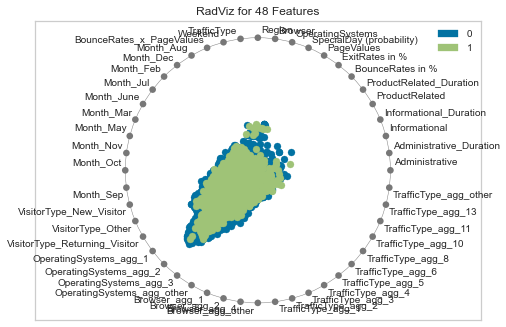

<AxesSubplot:title={'center':'RadViz for 48 Features'}>

In [295]:
visualizer = RadViz(classes=[0, 1])
visualizer.fit(X, y)
visualizer.transform(X)
visualizer.show() 

In [104]:
from sklearn.model_selection import GroupKFold

In [122]:
from sklearn.model_selection import train_test_split

In [115]:
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, recall_score

In [142]:
cor = X_train.corr()
cor = cor.fillna(1)

In [143]:
keep_columns = [True]*len(X_train.columns)
for i in range(len(X_train.columns)-1):
    for j in range(i+1,len(X_train.columns)):
        if abs(cor.iloc[i,j]) >= 0.8:       
            if keep_columns[j] is True:
                keep_columns[j] = False
print(len(keep_columns))
selected_columns = X_train.columns[keep_columns]
X_out = X_train[selected_columns]

print('The following columns are present in the new data:')
print(selected_columns)
print(f'The old data had {X_train.shape[1]} features. The new df has {X_out.shape[1]} features.')
print(y_train.shape)
X_out.head()

16
The following columns are present in the new data:
Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'BounceRates in %',
       'PageValues'],
      dtype='object')
The old data had 16 features. The new df has 7 features.
(6875,)


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,BounceRates in %,PageValues
5455,0,0.000000,0,0.0,1,0.0,0.000000
5456,3,40.200000,0,0.0,11,0.0,0.000000
5457,1,63.400000,0,0.0,3,0.0,42.293068
5458,6,618.066667,0,0.0,50,0.0,28.068050
5459,0,0.000000,0,0.0,2,0.0,0.000000


In [144]:
selected_columns_fnl = selected_columns
selected_columns = selected_columns[0:]
import statsmodels.api as sm

def backwardElimination(x, y, sl, columns):
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(y, x).fit()
        maxVar = max(regressor_OLS.pvalues)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
                    
    regressor_OLS.summary()
    return x, columns

SL = 0.05
data_modeled, selected_columns_fnl = backwardElimination(X_out.values, y_train, SL, selected_columns)

In [145]:
print('The following columns remain based on p-value selection:')
print(selected_columns_fnl)
data_red = pd.DataFrame(data = data_modeled, columns = selected_columns_fnl)
print(f'After selection by Pearson Correlation, we had {X_out.shape[1]} features.')
print(f'After selection by p-value, we have {data_red.shape[1]} features.')

The following columns remain based on p-value selection:
Index(['Administrative', 'ProductRelated', 'PageValues'], dtype='object')
After selection by Pearson Correlation, we had 7 features.
After selection by p-value, we have 3 features.


In [158]:
X

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates in %,ExitRates in %,PageValues,SpecialDay (probability),OperatingSystems,Browser,TrafficType,VisitorType,Weekend,Revenue


In [167]:
options = ['June','Jul','Aug','Sep','Oct','Nov','Dec']  
X = df[df['Month'].isin(options)]
y = df['Revenue']
X = X.drop(['Month','Region'], axis=1) 
X

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates in %,ExitRates in %,PageValues,SpecialDay (probability),OperatingSystems,Browser,TrafficType,VisitorType,Weekend,Revenue
5455,0,0.000000,0,0.0,1,207.570248,0.000000,0.007937,0.000000,0.0,2,2,5,2,0,False
5456,3,40.200000,0,0.0,11,201.133333,0.000000,0.020000,0.000000,0.0,2,2,1,0,0,False
5457,1,63.400000,0,0.0,3,120.400000,0.000000,0.000000,42.293068,0.0,1,1,3,0,0,True
5458,6,618.066667,0,0.0,50,1342.083333,0.000000,0.004386,28.068050,0.0,2,2,11,0,0,True
5459,0,0.000000,0,0.0,2,7.000000,0.000000,0.100000,0.000000,0.0,2,2,1,2,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,3,145.000000,0,0.0,53,1783.791667,0.007143,0.029031,12.241717,0.0,4,6,1,2,1,False
12326,0,0.000000,0,0.0,5,465.750000,0.000000,0.021333,0.000000,0.0,3,2,8,2,1,False
12327,0,0.000000,0,0.0,6,184.250000,0.083333,0.086667,0.000000,0.0,3,2,13,2,1,False
12328,4,75.000000,0,0.0,15,346.000000,0.000000,0.021053,0.000000,0.0,2,2,11,2,0,False


In [216]:
options = ['June','Jul','Aug','Sep','Oct','Nov','Dec']  
X = df[df['Month'].isin(options)]
y = X['Revenue']
X = X.drop(['Month','Region'], axis=1)

In [217]:
options = ['Feb','Mar']  
X_test = df[df['Month'].isin(options)]
X_test = X_test.drop(['Month','Region'], axis=1) 
y_test = df.loc[df['Month'].isin(options), ['Revenue']].values
y_test = np.reshape(y_test, (len(y_test), 1))

In [218]:
y_test = np.reshape(y_test, (len(y_test), ))
y_test

array([False, False, False, ..., False, False, False])

In [213]:
oof_preds = np.zeros(len(df))
oof_true = np.zeros(len(df))
split = 5
cv = StratifiedKFold(n_splits=split)
recall_folds = np.zeros(split)

for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[test_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[test_idx]

    model = xgb.XGBClassifier(**params)
    model.fit(X_train_fold, y_train_fold)
    y_pred_fold = model.predict(X_val_fold)

    recall_fold = recall_score(y_val_fold, y_pred_fold)
    recall_folds[i] = recall_fold

    oof_preds[test_idx] = y_pred_fold
    oof_true[test_idx] = y_val_fold
     
avg_recall = np.mean(recall_folds)

model = xgb.XGBClassifier(**params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
   
test_metrics = {}
test_metrics['Recall'] = recall_score(y_test, y_pred)
test_metrics['Accuracy'] = accuracy_score(y_test, y_pred)
test_metrics['Precision'] = precision_score(y_test, y_pred)
test_metrics['ROC-AUC'] = roc_auc_score(y_test, y_pred)

oof_preds[X_test.index] = y_pred
oof_true[X_test.index] = y_test

recall = recall_score(oof_true, oof_preds)
accuracy = accuracy_score(oof_true, oof_preds)
precision = precision_score(oof_true, oof_preds)

print(test_metrics)
print(f"Test Recall: {test_metrics['Recall']}")
print(f"Test Accuracy: {test_metrics['Accuracy']}")
print(f"Test Precision: {test_metrics['Precision']}")
print(f"Test ROC-AUC: {test_metrics['ROC-AUC']}")
print(f"Avg Recall for {split} folds: {avg_recall:.3f}")
print(f"OOF Recall: {recall:.3f}")
print(f"OOF Accuracy: {accuracy:.3f}")
print(f"OOF Precision: {precision:.3f}")

{'Recall': 1.0, 'Accuracy': 1.0, 'Precision': 1.0, 'ROC-AUC': 1.0}
Test Recall: 1.0
Test Accuracy: 1.0
Test Precision: 1.0
Test ROC-AUC: 1.0
Avg Recall for 5 folds: 1.000
OOF Recall: 1.000
OOF Accuracy: 1.000
OOF Precision: 1.000


In [128]:
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [222]:
oof_preds = np.zeros(len(df))
oof_true = np.zeros(len(df))
split = 5
cv = StratifiedKFold(n_splits=split)
recall_folds = np.zeros(split)

for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[test_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[test_idx]

    model = lgb.LGBMClassifier()
    model.fit(X_train_fold, y_train_fold)
    y_pred_fold = model.predict(X_val_fold)

    recall_fold = recall_score(y_val_fold, y_pred_fold)
    recall_folds[i] = recall_fold

    oof_preds[test_idx] = y_pred_fold
    oof_true[test_idx] = y_val_fold
     
avg_recall = np.mean(recall_folds)

model = lgb.LGBMClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
   
test_metrics = {}
test_metrics['Recall'] = recall_score(y_test, y_pred)
test_metrics['Accuracy'] = accuracy_score(y_test, y_pred)
test_metrics['Precision'] = precision_score(y_test, y_pred)
test_metrics['ROC-AUC'] = roc_auc_score(y_test, y_pred)

oof_preds[X_test.index] = y_pred
oof_true[X_test.index] = y_test

recall = recall_score(oof_true, oof_preds)
accuracy = accuracy_score(oof_true, oof_preds)
precision = precision_score(oof_true, oof_preds)

print(test_metrics)
print(f"Test Recall: {test_metrics['Recall']}")
print(f"Test Accuracy: {test_metrics['Accuracy']}")
print(f"Test Precision: {test_metrics['Precision']}")
print(f"Test ROC-AUC: {test_metrics['ROC-AUC']}")
print(f"Avg Recall for {split} folds: {avg_recall:.3f}")
print(f"OOF Recall: {recall:.3f}")
print(f"OOF Accuracy: {accuracy:.3f}")
print(f"OOF Precision: {precision:.3f}")

{'Recall': 1.0, 'Accuracy': 1.0, 'Precision': 1.0, 'ROC-AUC': 1.0}
Test Recall: 1.0
Test Accuracy: 1.0
Test Precision: 1.0
Test ROC-AUC: 1.0
Avg Recall for 5 folds: 1.000
OOF Recall: 1.000
OOF Accuracy: 1.000
OOF Precision: 1.000


In [129]:
oof_preds = np.zeros(len(df))
oof_true = np.zeros(len(df))
split = 5
cv = GroupKFold(n_splits=split)
recall_folds = np.zeros(split)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

for i, (train_idx, test_idx) in enumerate(cv.split(X, y, groups=X['Month'])):
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[test_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[test_idx]

    model = RandomForestClassifier()
    model.fit(X_train_fold, y_train_fold)
    y_pred_fold = model.predict(X_val_fold)

    recall_fold = recall_score(y_val_fold, y_pred_fold)
    recall_folds[i] = recall_fold

    oof_preds[test_idx] = y_pred_fold
    oof_true[test_idx] = y_val_fold
     
avg_recall = np.mean(recall_folds)

model = xgb.XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
   
test_metrics = {}
test_metrics['Recall'] = recall_score(y_test, y_pred)
test_metrics['Accuracy'] = accuracy_score(y_test, y_pred)
test_metrics['Precision'] = precision_score(y_test, y_pred)
test_metrics['ROC-AUC'] = roc_auc_score(y_test, y_pred)

oof_preds[y_test.index] = y_pred
oof_true[y_test.index] = y_test

recall = recall_score(oof_true, oof_preds)
accuracy = accuracy_score(oof_true, oof_preds)
precision = precision_score(oof_true, oof_preds)

print(test_metrics)
print(f"Test Recall: {test_metrics['Recall']}")
print(f"Test Accuracy: {test_metrics['Accuracy']}")
print(f"Test Precision: {test_metrics['Precision']}")
print(f"Test ROC-AUC: {test_metrics['ROC-AUC']}")
print(f"Avg Recall for {split} folds: {avg_recall:.3f}")
print(f"OOF Recall: {recall:.3f}")
print(f"OOF Accuracy: {accuracy:.3f}")
print(f"OOF Precision: {precision:.3f}")

{'Recall': 0.5766871165644172, 'Accuracy': 0.8949075575737918, 'Precision': 0.706766917293233, 'ROC-AUC': 0.7657915151056474}
Test Recall: 0.5766871165644172
Test Accuracy: 0.8949075575737918
Test Precision: 0.706766917293233
Test ROC-AUC: 0.7657915151056474
Avg Recall for 5 folds: 0.568
OOF Recall: 0.528
OOF Accuracy: 0.895
OOF Precision: 0.718
